## Exercise 5
Description: Fit Type Ia supernovae distance modulus vs redshift data
 - Created sometime in the 21st century Harrison B. Prosper
 - Updated sometime also in the 21st century Javier M. Duarte

In [1]:
# load some Python modules into memory
import os,sys          # operating system, system modules
sys.path.insert(0,'../python')
from histutil import * # load some utilities built on PyRoot
from time import sleep # well...kind of obvious, no?
import ROOT as rt     # load all of PyROOT

Welcome to JupyROOT 6.12/07


In [2]:
# procedure to make nice plots
def makePlots(data, OM, OL, H, zmin, zmax, mumin, mumax, tmax, amax, NP):

    omegaM = OM.getVal()
    omegaL = OL.getVal()
    q = H.getVal()

    # Copy data into arrays
    xx = array('d')
    ex = array('d')
    yy = array('d')
    ey = array('d')

    chi2 = 0.0
    ndata = data.numEntries()
    for ii in xrange(ndata):
        row = data.get(ii)
        xx.append(row['z'].getVal())
        ex.append(0)
        yy.append(row['x'].getVal())
        ey.append(row['dx'].getVal())
        mu = distanceModulus(xx[-1],
                     omegaM,
                     omegaL, q)
        c = (yy[-1]-mu)/ey[-1]
        chi2 += c*c

    gd = mkgraphErrors(xx, yy, ex, ey,
               "redshift z",
               "distance modulus #mu", 
               zmin, zmax,
               ymin=mumin,
               ymax=mumax, color=rt.kBlack)
    gd.SetName('data')
    gd.SetMarkerSize(0.2)

    # Create model plot
    nz = 200
    zstep = (zmax-zmin)/nz
    zz = array('d')
    mu = array('d')
    for ii in xrange(nz):
        zz.append( (ii+0.5)*zstep )
        mu.append( distanceModulus(zz[-1],
                       omegaM,
                       omegaL, q) )

    gm = mkgraph(zz, mu,
             "redshift z", "distance modulus #mu", 
             zmin, zmax, color=rt.kRed, lwidth=2)
    gm.SetName('model')

    # Create a vs H0 t plot
    np = 500
    a = array('d')
    t = array('d')

    for ii in xrange(np):
        a.append(0)
        t.append(0)

    scaleFactor(amax, omegaM, omegaL, np, t, a)
    ga = mkgraph(t, a,
             "t/T_{0}", "a(t)", 
             0, tmax, color=rt.kBlue, lwidth=2)
    ga.SetName('scaleFactor')

    # Create Omega vs a plot
    O = array('d')
    for ii in xrange(np):
        O.append(0)

    Omega(amax, omegaM, omegaL, np, a, O)
    gO = mkgraph(a, O,
             "a", "#Omega(a)", 
             0, amax, color=rt.kBlue, lwidth=2)
    gO.SetName('Omega')

    # Create vertical line at a = 1
    x = array('d'); x.append(1); x.append(1)
    y = array('d'); y.append(0); y.append(5)
    glineV = mkgraph(x, y, '', '', 0, 2, color=rt.kMagenta+1, lwidth=2)
    glineV.SetName('vline')

    # Create horizontal line at a = 1
    x = array('d'); x.append(0); x.append(tmax)
    y = array('d'); y.append(1); y.append(1)
    glineH = mkgraph(x, y, '', '', 0, tmax, color=rt.kMagenta+1, lwidth=2)
    glineH.SetName('line')

    return (chi2, ndata-NP, gd, gm, ga, gO, glineH, glineV)

In [3]:
print "\n","="*80 
print "\t\tType Ia Supernovae"
print "="*80
# compile distance modulus function and import into Python
#rt.gROOT.ProcessLine(open('distanceModulus.cc').read())
rt.gROOT.ProcessLine('.L distanceModulus.cc++')
from ROOT import distanceModulus, scaleFactor, Omega


		Type Ia Supernovae


Info in <TUnixSystem::ACLiC>: creating shared library /home/cms.woodson/statistics-das/5/./distanceModulus_cc.so


In [4]:
# make a workspace so that we can use its factory method
wspace = rt.RooWorkspace('TypeIa')

# define parameter ranges
zmin  = 0.0    # min(red-shift)
zmax  = 1.5    # max(red-shift)
mumin = 32.0   # min(distance modulus)
mumax = 48.0   # max(distance modulus)
tmax  =  3.0   # max(H_0 t)
amax  = 10.0   # max(scale factor)
    
# create parameter for name of Type Ia supernova
name = rt.RooStringVar('name', 'TypeIa', 'name of type Ia')

# create red shift observable and return it to Python from RooFit
wspace.factory('z[%f, %f]' % (zmin, zmax))
z = wspace.var('z')

# create distance modulus observable
wspace.factory('x[%f, %f]' % (mumin, mumax))
x = wspace.var('x')

# create uncertainty in distance modulus observable
wspace.factory('dx[0, 2]')
dx = wspace.var('dx')

# create model parameters
NP = 1     # number of free parameters

# if a parameter is not used, make it constant, e.g.:
# OM.setConstant()
    
# Omega_M
wspace.factory('OM[0.5, 0, 200]')
OM = wspace.var('OM')

# Omega_Lambda
wspace.factory('OL[0.5, 0, 200]')
OL = wspace.var('OL')

# A parameter closely related to Hubble constant
wspace.factory('H[70, 0, 200]')
H = wspace.var('H')

# create distance modulus parameter 
# note use of compiled C++ program
mu = rt.RooFormulaVar('mu', '#mu',
                      'distanceModulus(z, OM, OL, H)',
                      rt.RooArgList(z, OM, OL, H))
# import mu into workspace so the latter "knows" about it
# (last argument is a workaround a PyROOT bug)
getattr(wspace,'import')(mu, rt.RooCmdArg())

# create model to be fitted
wspace.factory('Gaussian::model(x, mu, dx)')
model  = wspace.pdf('model')

#----------------------------------------------------------
# read in Type Ia data
#----------------------------------------------------------
# suppress all but fatal messages
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.FATAL)
    
data = rt.RooDataSet.read('SCPUnion2.1.txt',
                          rt.RooArgList(name, z, x, dx))
    
ndata = data.numEntries()
print "\nnumber of observations: %d" % ndata
    
# one way to access data from a RooDataSet
for ii in range(ndata):
    if ii % 100 == 0:
        d = data.get(ii)
        print "%5d %-8s\t%10.3f\t%10.4f +/- %-10.4f"%\
              (ii,
               d['name'].getVal(),
               d['z'].getVal(),
               d['x'].getVal(),
               d['dx'].getVal())


number of observations: 580
    0         	     0.028	   35.3466 +/- 0.2239    
  100         	     0.065	   37.3067 +/- 0.1628    
  200         	     0.194	   39.9615 +/- 0.1264    
  300         	     0.620	   43.2280 +/- 0.3903    
  400         	     0.710	   43.0220 +/- 0.1843    
  500         	     0.564	   42.3729 +/- 0.2920    
[#1] INFO:ObjectHandling -- RooWorkspace::import(TypeIa) importing RooFormulaVar::mu


In [5]:
#----------------------------------------------------------
# now fit model to observations
#----------------------------------------------------------
print "="*80
swatch = rt.TStopwatch()
swatch.Start()

results = model.fitTo(data, rt.RooFit.Save())
print "real time: %10.3f s" % swatch.RealTime()
print "="*80
results.Print()
print "="*80

#----------------------------------------------------------
# plot results of fit
#----------------------------------------------------------
# see histutil.py
setStyle()

chi2, NDF, gd, gm, ga, gO, glineH, glineV = makePlots(data, OM, OL, H,
                                                      zmin, zmax,
                                                      mumin, mumax,
                                                      tmax, amax, NP)

real time:      1.537 s
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 H            7.00000e+01  2.00000e+01    0.00000e+00  2.00000e+02
     2 OL           5.00000e-01  2.50000e-01    0.00000e+00  2.00000e+02
     3 OM           5.00000e-01  2.50000e-01    0.00000e+00  2.00000e+02
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=1565.86 FROM MIGRAD    STATUS=INITIATE       12 CALLS          13 TOTAL
                     EDM= unknown      STRATEGY= 1      NO

Info in <TCanvas::Print>: png file ./fig_fit_results.png has been created


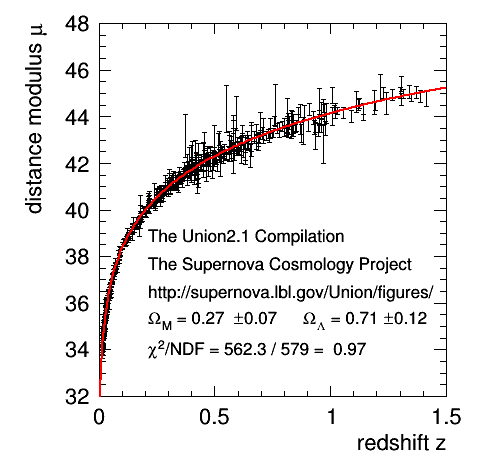

In [7]:
# plot fit
cf = rt.TCanvas("fig_fit_results", "SN1a", 10, 10, 500, 500)
cf.cd()
gd.Draw("ap")
gm.Draw("c same")

wrf = Scribe(0.30, 0.50)
wrf.write("The Union2.1 Compilation")
wrf.write("The Supernova Cosmology Project")
wrf.write("http://supernova.lbl.gov/Union/figures/")
wrf.write("#Omega_{M} = %4.2f #pm%-4.2f    "\
          "#Omega_{#Lambda} = %4.2f #pm%-4.2f" % (OM.getVal(),
                                                  OM.getError(),
                                                  OL.getVal(),
                                                  OL.getError()))
wrf.write("#chi^{2}/NDF = %5.1f / %d = %5.2f" % (chi2, NDF, chi2/NDF))

cf.Update()
cf.SaveAs(".png")
cf.Draw()

NameError: name 'TCanvas' is not defined

Info in <TCanvas::Print>: png file ./fig_scaleFactor.png has been created


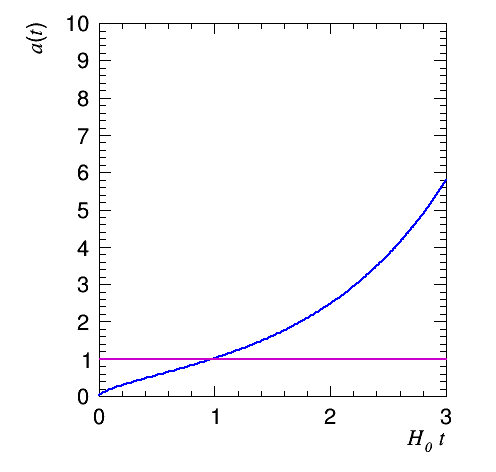

In [8]:
# plot a(t) vs H_0 t
ca = rt.TCanvas("fig_scaleFactor", "SN1a scalefactor",
                 516, 10, 500, 500)
ca.cd()
htmp = mkhist1('htmp', '#font[12]{H_{0} t}',
               '#font[12]{a}(#font[12]{t})',
               50, 0, tmax, ymin=0, ymax=10)
htmp.Draw()
ga.Draw('same c')
glineH.Draw('same c')
ca.Update()
ca.SaveAs(".png")
ca.Draw()

# plot Omega vs a
cO = rt.TCanvas("fig_Omega", "SN1a Omega", 200, 310, 500, 500)
cO.cd()
cO.SetLogy()
htmp2 = mkhist1('htmp2', '#font[12]{a}', '#Omega(#font[12]{a})',
                50, 0, 2, ymin=0.1, ymax=1000)
htmp2.Draw()
gO.Draw('same c')
glineH.Draw('same c')
cO.Update()
cO.SaveAs(".png")
cO.Draw()